## Rohan Sanjay
## MWF 9:00 am MATH 408
## Experimental Project
## 11/13/2020

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats import stattools
from scipy import integrate
import math
import yfinance as yf
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import seaborn as sns

(1) Pairs trading is a common trading strategy in mathematical finance that relies on statistical analysis. The idea behind pairs trading is to find two securities that have some underlying link and make trades based on it. The two securities are generally from the same industry, in the same supply chain, manufacture the same product, or have some economic link. Once you find the two related securities that historically move together, you take a long position on one and a short position on the other—a market neutral strategy. Specifically, the link refers to finding pairs that are cointegrated. If two time series are cointegrated, then there is a linear combination of them that will vary around a mean. In other words, the spread between two securities that are cointegrated will come from the same probability distrubution with parameters that do not change over time. 

(2) The spread of prices of cointegrated securities can be calculated using linear regression. Once calculated you can normalize the spread to get a z-score, which can be used as a trading signal. This assumes that the underlying distribution of the spread is normal. As such, you can long the spread when the z-score is below -1 (betting that the spread will widen/increase) and short the spread when the z-score is above 1 (betting that the spread will shrink/decrease). You can exit your positions when the z-score approaches 0. Longing the spread refers to taking a long position on the higher priced stock and a short position on the lower priced stock. Shorting the spread is the opposite. 

(3) The different pairs of securities will be tested for cointegration using the statsmodels coint() function. This uses the Engle-Grange two-step cointegration test, which constructs residuals based on a static regression. The residuals will be stationary if the time series is cointegrated (using Augmented Dickey-Fuller test). The null hypothesis for the Engle-Granger test is no cointegration. The alterative hypothesis is that cointegration exists. 

(4) For the experiment, five different pairs will be tested for cointegration: Moderna (MRNA) & BioNTech (BNTX), Apple (AAPL) & Google (GOOGL), Delta (DAL) and Southwest (LUV), Lyft (LYFT) & Uber (UBER), Disney (DIS) & Netflix (NFLX). This test is reasonable because each pair represents two securities from the same industry. Furthermore, pricing data from the last 6 months will be used. During this time frame, companies generally moved based on how their industry as a whole was impacted by COVID-19. While it may seem reasonable to test for cointegration through a list of securities, this method can incur a large amount of multiple comparisons bias. Multiple comparisons bias is the greater chance of incorrectly generating a significant p-value. To prevent this, as done in this experiment, it is better to only test for cointegration in pairs that you suspect, based on some knowledge, have an economic link and can thus be cointegrated. 

(5) & (6) A signifiance level of 0.05 will be used in our experiment when performing the cointegration test on our pairs. As discussed above, the close price for each security from May 2020 - November 2020 will be pulled using market pricing data from yahoo finance. The statsmodels Engle-Granger cointegration test will then be performed on the pricing data of the two securities in the pair. 

In [11]:
tickers = ['MRNA', 'BNTX', 'AAPL', 'GOOGL', 'DAL', 'LUV', 'LYFT', 'UBER', 'DIS', 'NFLX']
data = yf.download(tickers,'2020-05-01', '2020-11-01', progress=False)['Close']

for i in range(0, len(tickers), 2):
    score, pvalue, _ = coint(data[tickers[i]], data[tickers[i + 1]])
    print(tickers[i], tickers[i + 1], 'p-value:', pvalue)

MRNA BNTX p-value: 0.0006049648180368427
AAPL GOOGL p-value: 0.4520090468494
DAL LUV p-value: 0.006823448135693724
LYFT UBER p-value: 0.6824955417062124
DIS NFLX p-value: 0.3205248568183847


(7) For Apple & Google, Lyft & Uber, and Disney & Netflix, the p-value is greater than our significance level of 0.05. Therefore, we do not reject the null hypothesis for these pairs—they are not cointegrated. Moderna & BioNTech and Delta & Southwest both resulted in p-values below our signifiance level of 0.05, so the null hypothesis is rejected—the pairs are cointegrated. 

The prices and spreads for the cointegrated pairs are plotted below. 

In [70]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

size = 18
plt.rc('legend',fontsize=size)
plt.rc('xtick', labelsize=size) 
plt.rc('ytick', labelsize=size)
plt.rcParams.update({'font.size': size})

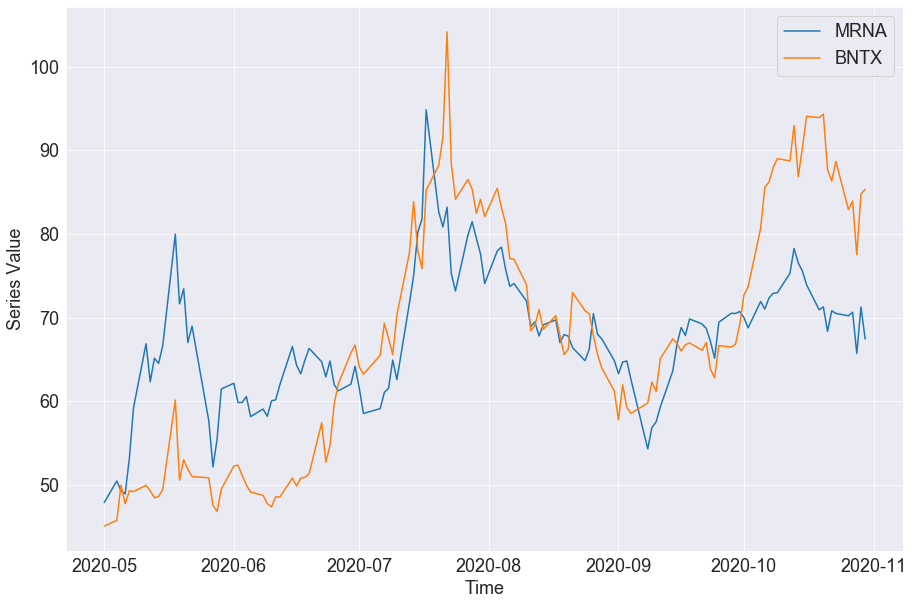

In [71]:
sns.set_style(style="darkgrid")

X1 = data[tickers[0]]
X2 = data[tickers[1]]

plt.figure(figsize=(15,10))
plt.plot(X1.index, X1.values)
plt.plot(X1.index, X2.values)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([X1.name, X2.name]);

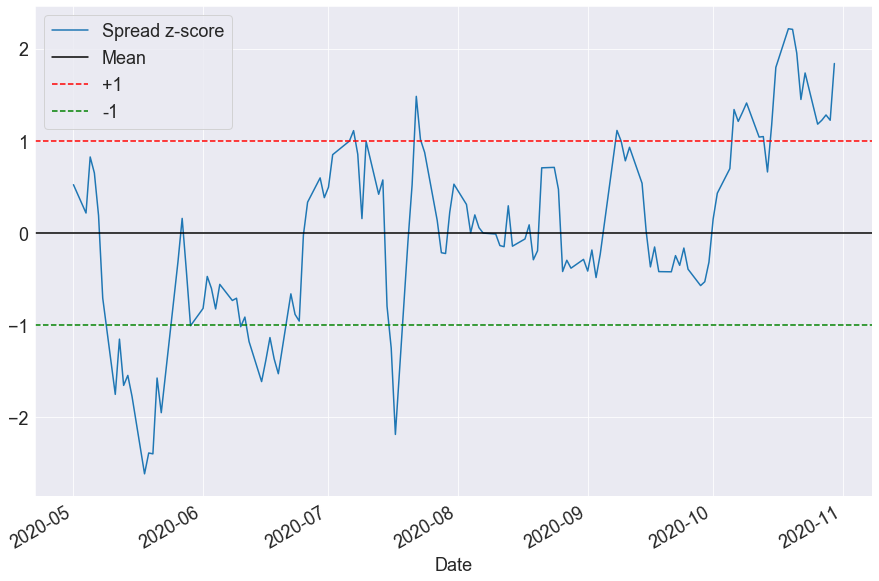

In [72]:
X1 = sm.add_constant(X1)
results = sm.OLS(X2, X1).fit()
X1 = X1[tickers[0]]
b = results.params[tickers[0]]
spread = X2 - b * X1

plt.figure(figsize=(15,10))
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

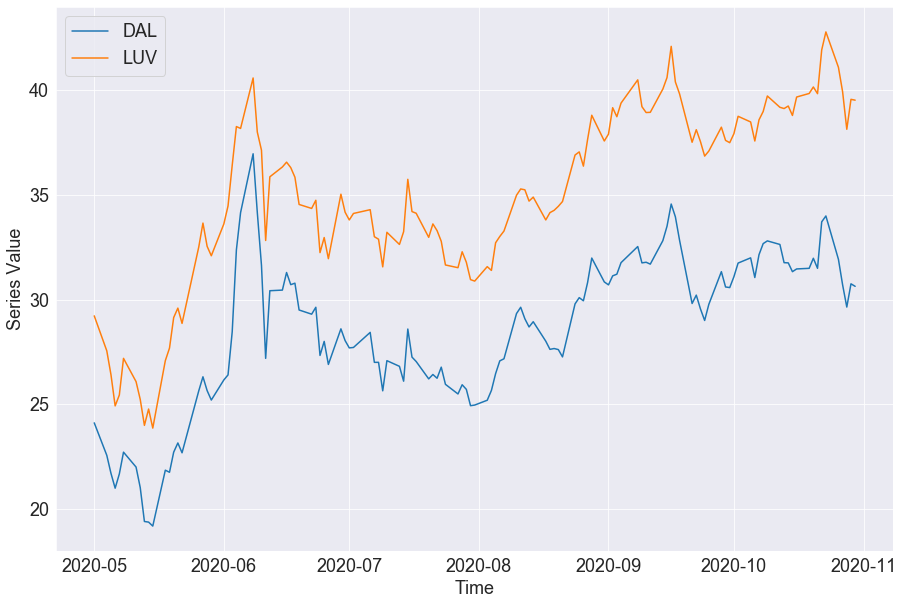

In [73]:
X1 = data[tickers[4]]
X2 = data[tickers[5]]

plt.figure(figsize=(15,10))
plt.plot(X1.index, X1.values)
plt.plot(X1.index, X2.values)
plt.xlabel('Time')
plt.ylabel('Series Value')
plt.legend([X1.name, X2.name]);

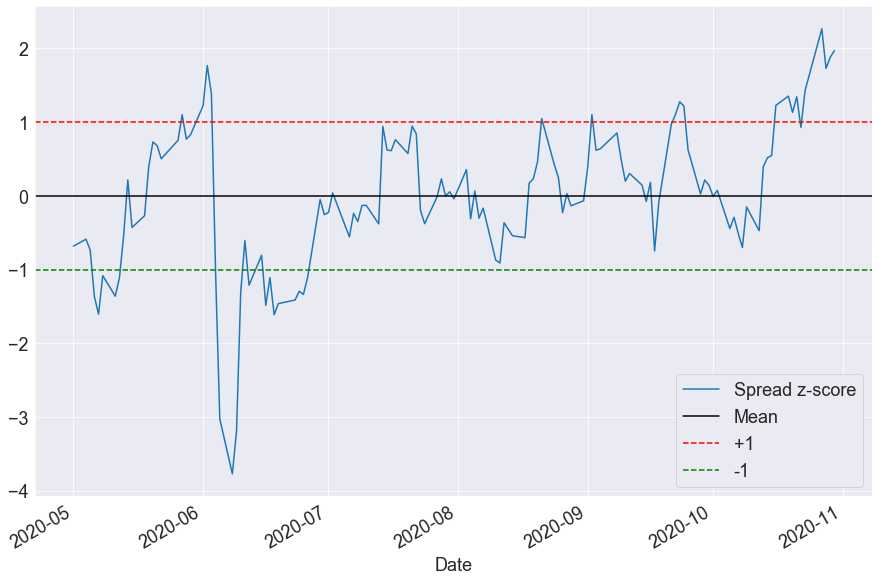

In [74]:
X1 = sm.add_constant(X1)
results = sm.OLS(X2, X1).fit()
X1 = X1[tickers[4]]
b = results.params[tickers[4]]
spread = X2 - b * X1

plt.figure(figsize=(15,10))
zscore(spread).plot()
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

A simple strategy as discussed before is to long the spread when the z-score is below -1, short the spread when the z-score is above 1, and exit positions when the z score crosses 0. But taking the z-score over a large time interval can be inaccurate based on market trends. For example, average prices prior to COVID-19 are not necessarily representative of today. A such, traders often use moving averages and kalman filters.

(8) In summary, pairs trading is trading strategy based on an underlying statistical test of cointegration. After finding two cointegrated securities, you can trade long and short based on the spread. Since the strategy is market neutral, it guards against market swings and can still make money from the hedged positions even when the market falls. It is important to prevent multiple comparison bias when determining pairs. This can be done by only testing pairs for cointegration that are predicted to have some underlying economic link or having extra verification steps when testing many pairs. There are also alternative cointegration tests such as the Johansen test that can be used instead of Engle-Granger. It should also be noted that out of sample tests of cointegration should be done on pairs for different time periods. The cointegration relationship based on historical prices does not necessarily hold for future prices. Ultimately, pairs trading is a simple and fundamentally viable strategy that can be complicated and adapted as necessary. 